In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))

        out = Value(self.data ** other, (self, ), f'**{other}')

        def backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def backward():
            self.grad += out.data * out.grad
        out._backward = backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    


In [3]:
a = Value(1.0)

In [4]:
a = Value(2.0)
b = Value(-3)
c = Value(10)
d = -a
d

Value(data=-2.0)

In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

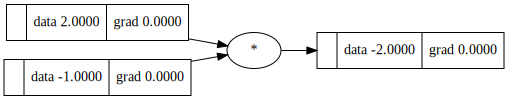

In [6]:
draw_dot(d)

In [7]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

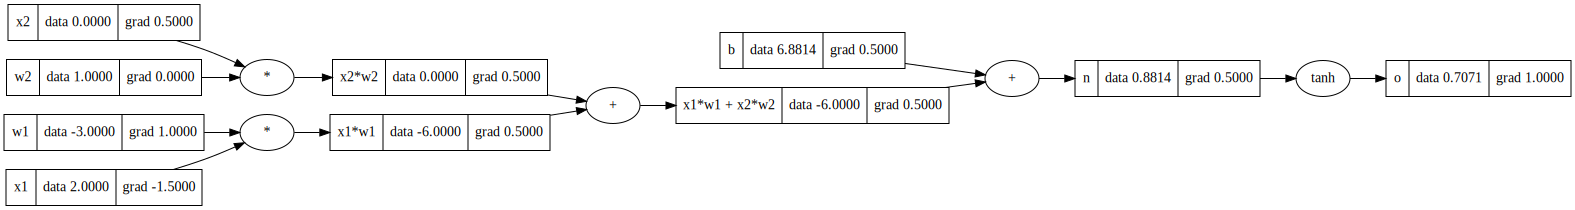

In [8]:
o.backward()
draw_dot(o)

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

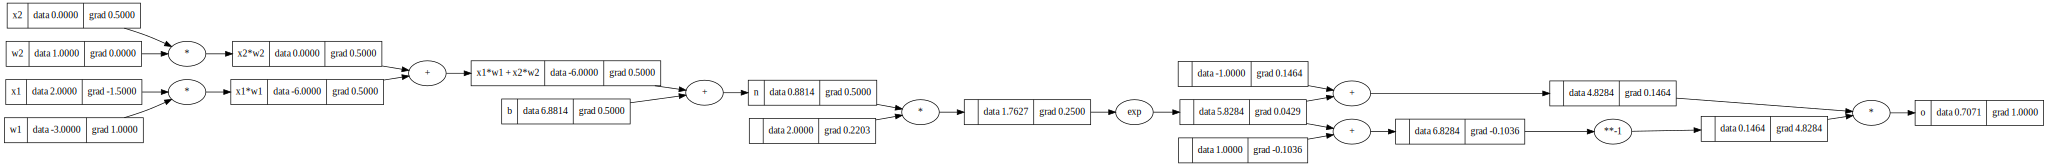

In [10]:
o.backward()
draw_dot(o)

In [11]:
import torch

In [12]:
x1 = torch.tensor([2.0], dtype=torch.float64); x1.requires_grad = True
x2 = torch.tensor([0.0], dtype=torch.float64); x2.requires_grad = True
w1 = torch.tensor([-3.0], dtype=torch.float64); w1.requires_grad = True
w2 = torch.tensor([1.0], dtype=torch.float64); w2.requires_grad = True
b = torch.tensor([6.8813735870195432], dtype=torch.float64); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print(x2.grad.item())
print(w2.grad.item())
print(x1.grad.item())
print(w1.grad.item())

0.7071067811865476
0.4999999999999999
0.0
-1.4999999999999996
0.9999999999999998


In [13]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [134]:
import random
random.seed(42)
class Neuron:

    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def  __init__(self, nin, nout) -> None:
        self.neurous = [Neuron(nin) for _ in range(nout)]

    
    def __call__(self, x):
        outs = [n(x) for n in self.neurous]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurous for p in neuron.parameters()]
        
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [30]:
x = [1.0, 2.0, -1.0]

o = n(x)
len(n.parameters())

41

In [35]:
n.layers[0].neurous[0].w[0].grad

-1.3722609374247599

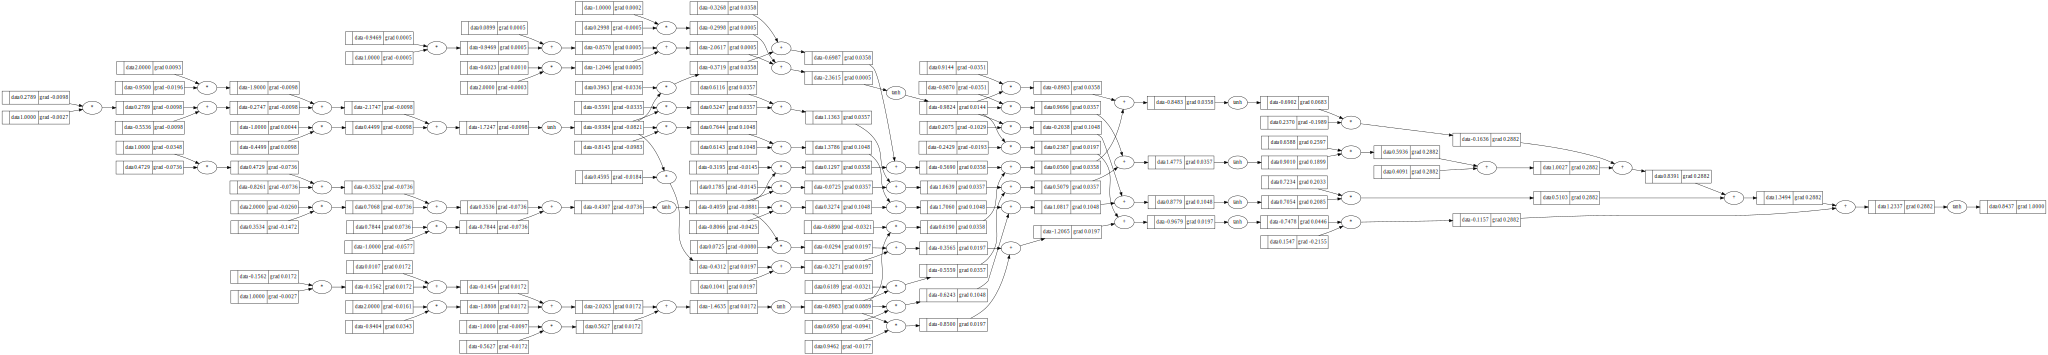

In [15]:

o.backward()
draw_dot(o)

In [150]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [151]:
losses = []

In [154]:

for step in range(20):

    ypred = [n(x) for x in xs]
    loss = sum((yhat - y)**2 for yhat, y in zip(ypred, ys))
    losses.append(loss.data)

    for p in n.parameters():
        p.grad = 0
    
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

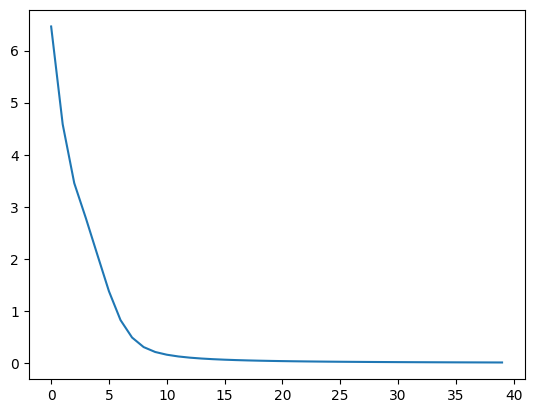

In [155]:
plt.plot(losses)

In [143]:
ypred

[Value(data=0.9473508648305156),
 Value(data=-0.9067790938916453),
 Value(data=-0.8952290765745662),
 Value(data=0.8807691998241052)]